In [1]:
import sys
import os
import re
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from collections import OrderedDict 
from operator import itemgetter
from collections import Counter
import itertools
from typing import *
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%config IPCompleter.greedy=True

# Load data

In [2]:
polish_corpora_path = '../../../polish_corpora.txt'
poleval2_path = '../../../poleval_2grams.txt'
poleval3_path = '../../../poleval_3grams.txt'
supertags_path = 'supertags.txt'

In [3]:
unigrams: Mapping[bytes, int] = {}  # word -> number of occurrences

with open(polish_corpora_path, encoding="utf8") as f:
    for line in tqdm(f, desc='Loading data...', position=0, leave=True, total=23011601):
        line = line.strip().lower().split()
        for word in line:
            _word = bytes(bytearray(word, 'UTF-8'))
            if _word in unigrams:
                unigrams[_word] += 1
            else:
                unigrams[_word] = 1

Loading data...: 100%|██████████| 23011601/23011601 [06:01<00:00, 63610.74it/s]


In [4]:
bigrams: Mapping[Tuple[bytes, bytes], int] = {}
    
with open(poleval2_path, encoding="utf8") as f:
    for line in tqdm(f, desc='Loading data...', position=0, leave=True, total=59134224):
        line = line.strip().lower().split()
        
        value: int =  int(line[0])
        if value <= 3:
            continue
            
        key: Tuple[bytes, bytes] = (bytes(bytearray(line[1], 'UTF-8')), bytes(bytearray(line[2], 'UTF-8')))
             
        if key in bigrams:
            bigrams[key].append(value)
        else:
            bigrams[key] = [value]

Loading data...: 100%|██████████| 59134224/59134224 [01:20<00:00, 737371.22it/s]


In [ ]:
trigrams: Mapping[Tuple[bytes, bytes], Tuple[bytes, int]] = {} 
total_iters, skipped1, skipped2 = 0, 0, 0

with open(poleval3_path, encoding="utf8") as f:
    for line in tqdm(f, desc='Loading data...', position=0, leave=True):
        total_iters += 1
        line = line.strip().lower().split()

        if len(line) != 4:
            skipped1 += 1
            continue
            
        if int(line[0]) == 1:
            skipped2 += 1
            continue
            
        key: Tuple[bytes, bytes] = (bytes(bytearray(line[1], 'UTF-8')),  bytes(bytearray(line[2], 'UTF-8')))
        value: Tuple[bytes, int] = (bytes(bytearray(line[3], 'UTF-8')), int(line[0]))
 
        if key in trigrams:
            trigrams[key].append(value)
        else:
            trigrams[key] = [value]

In [73]:
%%time
tags: Mapping[bytes, bytes] = {} 

with open(supertags_path, encoding='UTF-8') as f:
    for line in tqdm(f, position=0, leave=True, total=1781995):
        word, tag = line.strip().split(' ')
        tags[bytes(bytearray(word, 'UTF-8'))] = bytes(bytearray(tag, 'UTF-8'))

100%|█████████▉| 1781994/1781995 [00:02<00:00, 714968.40it/s]

CPU times: user 2.51 s, sys: 111 ms, total: 2.62 s
Wall time: 2.53 s


In [95]:
%%time
bigram_tags: Mapping[bytes, Mapping[bytes, int]] = {} 

for k, v in tqdm(bigrams.items()):
    if k[0] in tags and k[1] in tags:
        w1 = tags[k[0]]
        w2 = tags[k[1]]
        if w1 not in bigram_tags:
                bigram_tags[w1] = {w2: v[0]}
        else:
            bigram_tags[w1][w2] = v[0]

100%|██████████| 8472976/8472976 [00:09<00:00, 869893.04it/s]

CPU times: user 9.76 s, sys: 13.4 ms, total: 9.77 s
Wall time: 9.74 s


# Task 2
![alt text](images/task2.png "Title")

In [100]:
%%time
ALL_WORDS_NUMBER = sum([x[0] for x in bigrams.values()])

CPU times: user 339 ms, sys: 0 ns, total: 339 ms
Wall time: 337 ms


In [71]:
sentences = []
with open('sentences.txt', encoding='utf8') as f:
    for line in f:
        line = line.strip().lower().split()
        sentences.append(line)
        
print(len(sentences))

68


In [104]:
def simple_pbb_bigrams(w1: bytes, w2: bytes) -> int:
    """ Calculate number of occurrences of bigram (w1, w2) """
    assert type(w1) == bytes and type(w2) == bytes, f'Given type: {type(w1)} | {type(w2)}'
    return bigrams[(w1, w2)][0] if (w1, w2) in bigrams else 0


def simple_score(sentence: List[bytes], cond_pbb_func) -> float:
    pbb: float = 0.0
    n: int = len(sentence)
    for i in range(1, n):
        value = cond_pbb_func(w1=sentence[i - 1], w2=sentence[i]) + 1
        pbb += np.log(value)
    return pbb


def simple_score_with_tags(sentence: List[bytes], cond_pbb_func, alpha=0.1) -> float:
    pbb: float = 0.0
    n: int = len(sentence)
    for i in range(1, n):
        value = cond_pbb_func(w1=sentence[i - 1], w2=sentence[i]) + 1
        value_tag = 1
        
        if sentence[i - 1] in tags and sentence[i] in tags:
            t0, t1 = tags[sentence[i - 1]], tags[sentence[i]]
            if t0 in bigram_tags and t1 in bigram_tags[t0]:
                value_tag = bigram_tags[t0][t1]
                
        pbb += np.log(alpha * value + (1 - alpha) * value_tag)
    return pbb

In [105]:
def generate_permutations(sentence: List[bytes]) -> list:
    return list(itertools.permutations(sentence))

def order_permutations(permutations: List[bytes], scoring_function, cond_pbb_func) -> List[bytes]:
    scores = [scoring_function(x, cond_pbb_func) for x in permutations]
    return sorted(zip(scores, permutations), reverse=True)

def score_permuatations(valid_sentence: List[bytes], scoring_function, cond_pbb_func) -> Tuple[float, str]:
    permutations: List[bytes] = generate_permutations(sentence=valid_sentence)
    permutations = order_permutations(
        permutations=permutations, scoring_function=scoring_function, cond_pbb_func=cond_pbb_func
    )
    permutations = [y for x, y in permutations]
    best_decoded = list(map(lambda x: x.decode('utf8'), permutations[0]))
    for i, sentence in enumerate(permutations):
        if tuple(sentence) == tuple(valid_sentence):
            return 1 / (i + 1), best_decoded
    
    return 0.0, best_decoded

def final_score(cond_pbb_func, scoring_function) -> Tuple[float, int]:
    total_score: float = 0.0
    n_skipped: int = 0
    perfect_score: int = 0
    for i, sentence in enumerate(sentences):
        time.sleep(1)
        if len(sentence) > 7:
            n_skipped += 1
            print(f'{i+1} / {len(sentences)} | {sentence} ===> ??? / 1.0')
            print('Skipped because sentence is too long.')
            continue
        sentence_bytes = list(map(lambda x: bytes(bytearray(x, encoding='UTF-8')), sentence))
        score, best_sentence = score_permuatations(
            valid_sentence=sentence_bytes, 
            scoring_function=scoring_function,
            cond_pbb_func=cond_pbb_func
        )
        total_score += score
        if score == 1:
            perfect_score += 1
        print(f'{i+1} / {len(sentences)} | {sentence} ===> {score:.3f} / 1.0')
        print('My best: ', *best_sentence)
        
    return total_score / (len(sentences) - n_skipped), perfect_score

### Only bigrams

In [106]:
%%time
f_score = final_score(
    cond_pbb_func=simple_pbb_bigrams, 
    scoring_function=simple_score
)
print(f'Final score: {f_score}')

1 / 68 | ['judyta', 'dała', 'wczoraj', 'stefanowi', 'czekoladki'] ===> 0.016 / 1.0
My best:  wczoraj stefanowi judyta dała czekoladki
2 / 68 | ['babuleńka', 'miała', 'dwa', 'rogate', 'koziołki'] ===> 0.048 / 1.0
My best:  rogate miała dwa koziołki babuleńka
3 / 68 | ['wczoraj', 'wieczorem', 'spotkałem', 'pewną', 'piękną', 'kobietę'] ===> 1.000 / 1.0
My best:  wczoraj wieczorem spotkałem pewną piękną kobietę
4 / 68 | ['nasz', 'przedmiot', 'to', 'przetwarzanie', 'języka', 'naturalnego'] ===> 0.011 / 1.0
My best:  przetwarzanie przedmiot języka naturalnego to nasz
5 / 68 | ['jedną', 'grupę', 'prowadzi', 'jakub', 'michaliszyn'] ===> 0.062 / 1.0
My best:  prowadzi jedną grupę michaliszyn jakub
6 / 68 | ['wykładowcą', 'jest', 'paweł', 'rychlikowski'] ===> 0.333 / 1.0
My best:  rychlikowski paweł jest wykładowcą
7 / 68 | ['pan', 'paweł', 'prowadzi', 'również', 'dwie', 'pozostałe', 'grupy'] ===> 0.059 / 1.0
My best:  pozostałe dwie grupy prowadzi również pan paweł
8 / 68 | ['na', 'stronie', 'w

### Bigrams + tags

In [98]:
%%time
f_score = final_score(
    cond_pbb_func=simple_pbb_bigrams, 
    scoring_function=lambda x, y: simple_score_with_tags(x, y, alpha=0.9)
)
print(f'Final score: {f_score}')

1 / 68 | ['judyta', 'dała', 'wczoraj', 'stefanowi', 'czekoladki'] ===> 0.143 / 1.0
My best:  stefanowi judyta dała wczoraj czekoladki
2 / 68 | ['babuleńka', 'miała', 'dwa', 'rogate', 'koziołki'] ===> 0.167 / 1.0
My best:  miała dwa rogate koziołki babuleńka
3 / 68 | ['wczoraj', 'wieczorem', 'spotkałem', 'pewną', 'piękną', 'kobietę'] ===> 0.100 / 1.0
My best:  pewną piękną kobietę wczoraj wieczorem spotkałem
4 / 68 | ['nasz', 'przedmiot', 'to', 'przetwarzanie', 'języka', 'naturalnego'] ===> 0.004 / 1.0
My best:  języka naturalnego to przedmiot nasz przetwarzanie
5 / 68 | ['jedną', 'grupę', 'prowadzi', 'jakub', 'michaliszyn'] ===> 0.071 / 1.0
My best:  prowadzi jedną grupę jakub michaliszyn
6 / 68 | ['wykładowcą', 'jest', 'paweł', 'rychlikowski'] ===> 0.333 / 1.0
My best:  rychlikowski paweł jest wykładowcą
7 / 68 | ['pan', 'paweł', 'prowadzi', 'również', 'dwie', 'pozostałe', 'grupy'] ===> 0.056 / 1.0
My best:  pozostałe dwie grupy prowadzi również pan paweł
8 / 68 | ['na', 'stronie', 'w

# Task 3
![alt text](images/task3.png "Title")


In [203]:
%%time

word_to_tag, sufix_to_tag, tag_to_word = {}, {}, {}

with open('./supertags.txt','r',encoding='UTF-8') as f:
    for line in f:
        word, tag = line.strip().split(' ')
        word_to_tag[word] = tag
        
        if word[-3 :] in sufix_to_tag:
            sufix_to_tag[word[-3 :]].append(tag)
        else:
            sufix_to_tag[word[-3 :]] = [tag]
            
        if tag in tag_to_word:
            tag_to_word[tag].append(word)
        else:
            tag_to_word[tag] = [word]

            
for x in sufix_to_tag.keys():
    sufix_to_tag[x] = max(set(sufix_to_tag[x]), key=sufix_to_tag[x].count) 
    
len(word_to_tag), len(sufix_to_tag), len(tag_to_word)

CPU times: user 9.83 s, sys: 108 ms, total: 9.94 s
Wall time: 9.93 s


(1781994, 5824, 4034)

In [204]:
def generate_sentence(base_sentence: str) -> str:
    generated_sentence = ''

    for i, w in enumerate(base_sentence.lower().split(' ')):
        if w in word_to_tag:
            next_words = tag_to_word[
                word_to_tag[w]
            ]
        elif w[-3:] in sufix_to_tag:
            next_words = tag_to_word[
                sufix_to_tag[w[-3 :]]
            ]
        else:
            next_words = tag_to_word[
                np.random.choice(list(tag_to_word.keys()))
            ]
        next_word = np.random.choice(next_words)
        if i == 0:
            next_word = next_word.capitalize()
        generated_sentence += next_word + ' '
        
    return generated_sentence.strip() + '.'

In [4]:
generate_sentence(
    base_sentence='Mały Piotruś spotkał w niewielkiej restauracyjce wczoraj poznaną koleżankę.'
)

'Formalistyczny refrenista zaśnieżył pod niewybaczalnej rundzie pilno zmilitaryzowaną handicapa.'

In [5]:
generate_sentence(
    base_sentence='Gruby Stefan przeczytał we wczorajszej gazecie starannie przygotowaną analizę.'
)

'Fermowy legniczanin przystrzelał bazgrała przyjemniejszej calówce wodno pozalepianą zastaliby.'

In [27]:
generate_sentence(
    base_sentence='Zgodność gramatyczną sprawdzamy za pomocą tagów z pliku supertags.'
)

'Artystyczność ichtiolową gawrujemy za egerią kolejków z spisku popadło.'

# Task 4

In [209]:
def get_bigram_value(w1: str, w2: str):
    w1, w2 = bytes(bytearray(w1, 'UTF-8')), bytes(bytearray(w2, 'UTF-8'))
    if (w1, w2) in bigrams:
        return bigrams[(w1, w2)][0]
    return 0

def generate_sentence_bigrams(base_sentence: str) -> str:
    generated_sentence = [' ']

    for i, w in enumerate(base_sentence.lower().split(' ')):
        if w in word_to_tag:
            next_words = tag_to_word[
                word_to_tag[w]
            ]
        elif w[-3:] in sufix_to_tag:
            next_words = tag_to_word[
                sufix_to_tag[w[-3 :]]
            ]
        else:
            next_words = tag_to_word[
                np.random.choice(list(tag_to_word.keys()))
            ]
            
        pbb = np.array([get_bigram_value(w1=generated_sentence[-1], w2=w) for w in next_words])
        if pbb.sum() > 0:
            pbb = pbb / pbb.sum()
        else:
            pbb = np.ones(pbb.shape) / len(pbb)
            generated_sentence.append(' | ')

        next_word = np.random.choice(next_words, p=pbb)
        generated_sentence.append(next_word)
        
    return ' '.join(generated_sentence).strip()

In [213]:
generate_sentence_bigrams(
    base_sentence='Mały Piotruś spotkał w niewielkiej restauracyjce wczoraj poznaną koleżankę'
)

'|  rzeczywisty pan wyraził na niewielkiej zmianie wraz  |  zepsutą  |  rzezawiankę'

In [138]:
generate_sentence_bigrams(
    base_sentence='Mały Piotruś spotkał w niewielkiej restauracyjce wczoraj poznaną koleżankę.'
)

'|  drewnopochodny  |  władymir  |  zapieprzył  |  na niezbędnej ochronie szczególnie wyspecjalizowaną  |  vide'

# Task 5

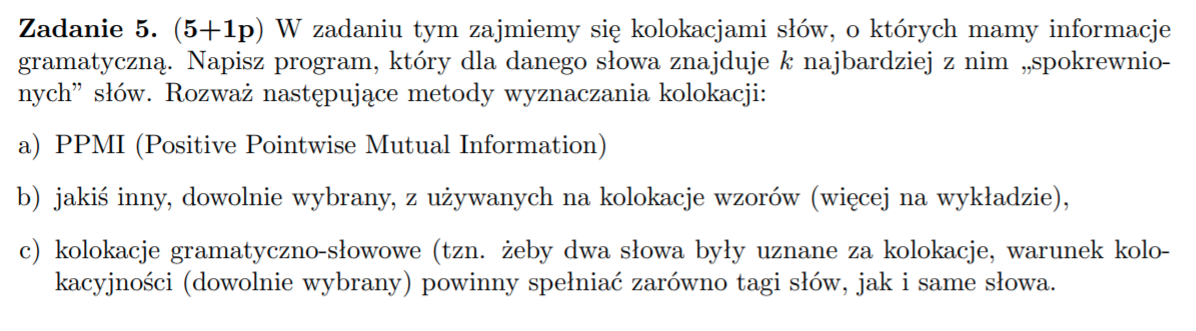
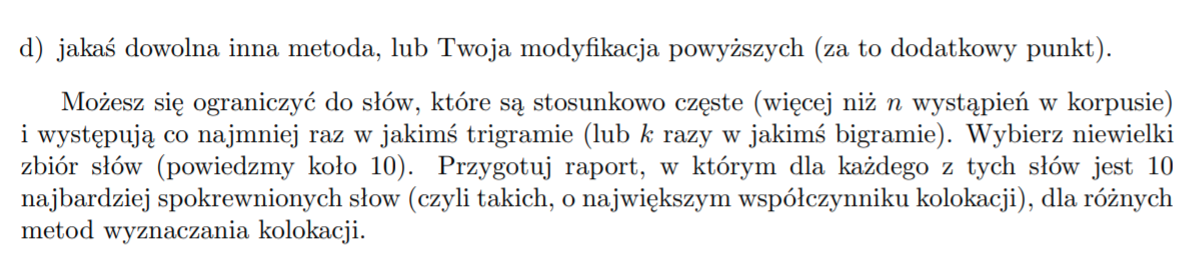

In [36]:
ALL_WORDS_NUMBER

410986693

In [168]:
def pbb_unigram(w: bytes):
    """ Calculate P(w1) """
    assert type(w) == bytes
    if w in unigrams:
        return unigrams[w] / ALL_WORDS_NUMBER
    return 1 / ALL_WORDS_NUMBER

def cond_pbb_bigrams(w1: bytes, w2: bytes) -> float:
    """ Calculate P(w2 | w1) """
    assert type(w1) == bytes and type(w2) == bytes
    cnt_w1_w2: float = 1.0 / ALL_WORDS_NUMBER
    if (w1, w2) in bigrams:
        cnt_w1_w2 = bigrams[(w1, w2)][0]
        
    return cnt_w1_w2 / (pbb_unigram(w=w1) * ALL_WORDS_NUMBER)

In [169]:
print('pan poseł: ', cond_pbb_bigrams(
    bytes(bytearray('pan', 'UTF-8')),
    bytes(bytearray('poseł', 'UTF-8')),
))

print('poseł pan: ', cond_pbb_bigrams(
    bytes(bytearray('poseł', 'UTF-8')),
    bytes(bytearray('pan', 'UTF-8')),
))

pan poseł:  0.4015677927786936
poseł pan:  5.680527152919791e-05


In [175]:
def PPMI(w1: bytes, w2: bytes) -> float:
    assert type(w1) == bytes and type(w2) == bytes
    Pw1w2 = cond_pbb_bigrams(w1=w1, w2=w2)
    Pw1 = pbb_unigram(w=w1)
    Pw2 = pbb_unigram(w=w2)
    return max(0, np.log(Pw1w2 / (Pw1 * Pw2)))

In [176]:
print('pan poseł: ',PPMI(
    bytes(bytearray('pan', 'UTF-8')),
    bytes(bytearray('poseł', 'UTF-8')),
))
print('poseł pan: ',PPMI(
    bytes(bytearray('poseł', 'UTF-8')),
    bytes(bytearray('pan', 'UTF-8')),
))

pan poseł:  13.172093694036263
poseł pan:  4.30859117719008


In [141]:
def PPMI_alpha(w1: bytes, w2: bytes, alpha: float = 0.75) -> float:
    assert type(w1) == bytes and type(w2) == bytes
    Pw1w2 = cond_pbb_bigrams(w1=w1, w2=w2) ** alpha
    Pw1 = pbb_unigram(w=w1) ** alpha
    Pw2 = pbb_unigram(w=w2) ** alpha
    return max(0, np.log(Pw1w2 / (Pw1 * Pw2)))

In [142]:
print('pan poseł: ',PPMI_alpha(
    bytes(bytearray('pan', 'UTF-8')),
    bytes(bytearray('poseł', 'UTF-8')),
))
print('poseł pan: ',PPMI_alpha(
    bytes(bytearray('poseł', 'UTF-8')),
    bytes(bytearray('pan', 'UTF-8')),
))

pan poseł:  9.879070270527198
poseł pan:  3.2314433828925604


In [143]:
def PSM(w1: bytes, w2: bytes) -> float:
    assert type(w1) == bytes and type(w2) == bytes
    Pw1w2 = cond_pbb_bigrams(w1=w1, w2=w2)
    Pw1 = pbb_unigram(w=w1) 
    Pw2 = pbb_unigram(w=w2)
    
    f = Pw1w2 * ALL_WORDS_NUMBER
    f_hat = (Pw1 * Pw2) * ALL_WORDS_NUMBER
    return f * (np.log(f) - np.log(f_hat) - 1)

In [144]:
print('pan poseł: ',PSM(
    bytes(bytearray('pan', 'UTF-8')),
    bytes(bytearray('poseł', 'UTF-8')),
))
print('poseł pan: ',PSM(
    bytes(bytearray('poseł', 'UTF-8')),
    bytes(bytearray('pan', 'UTF-8')),
))

pan poseł:  2008870404.5020828
poseł pan:  77243.06671224315


In [214]:
def PPMI_alpha_with_tags(w1: bytes, w2: bytes, alpha: float = 0.75) -> float:
    assert type(w1) == bytes and type(w2) == bytes
    Pw1w2 = cond_pbb_bigrams(w1=w1, w2=w2) ** alpha
    Pw1 = pbb_unigram(w=w1) ** alpha
    Pw2 = pbb_unigram(w=w2) ** alpha
    
    P_tag = 0.0
    if w1 in tags and w2 in tags:
        t0, t1 = tags[w1], tags[w2]
        if t0 in bigram_tags and t1 in bigram_tags[t0]:
            P_tag = bigram_tags[t0][t1] / sum(bigram_tags[t0].values())
    
    return max(0, np.log(Pw1w2 / (Pw1 * Pw2)) + P_tag) 

In [146]:
print('pan poseł: ',PPMI_alpha_with_tags(
    bytes(bytearray('pan', 'UTF-8')),
    bytes(bytearray('poseł', 'UTF-8')),
))
print('poseł pan: ',PPMI_alpha_with_tags(
    bytes(bytearray('poseł', 'UTF-8')),
    bytes(bytearray('pan', 'UTF-8')),
))

pan poseł:  9.87941291229523
poseł pan:  3.231786024660592


In [194]:
words = [
    'dziewczyna', 'kobieta', 'helikopter', 'śmigłowiec', 'piwo', 'wino'
]

metrics = [
    PPMI, PPMI_alpha, PSM, PPMI_alpha_with_tags
]

In [149]:
all_words_list = list(unigrams.keys())
len(all_words_list)

3591114

In [159]:
def find_similar(w1: bytes, k: int, metric_f):
    words_sorted: List[Tuple[bytes, float]] = [(w2, metric_f(w1, w2)) for w2 in all_words_list]
    words_sorted.sort(key=lambda x: x[1], reverse=True)
    return words_sorted[:k]

In [215]:
find_similar(
    w1=bytes(bytearray('helikopter', 'utf-8')),
    k=10,
    metric_f=PPMI_alpha_with_tags
)

[(b'ten', 0.14690060831531848),
 (b'kt\xc3\xb3ry', 0.14690060831531848),
 (b'taki', 0.14690060831531848),
 (b'jakikolwiek', 0.14690060831531848),
 (b'jaki\xc5\x9b', 0.14690060831531848),
 (b'nasz', 0.14690060831531848),
 (b'm\xc3\xb3j', 0.14690060831531848),
 (b'tw\xc3\xb3j', 0.14690060831531848),
 (b'kt\xc3\xb3rykolwiek', 0.14690060831531848),
 (b'\xc5\xbcaden', 0.14690060831531848)]

In [197]:
%%time
for metric_f in metrics:
    for w in words:
        print(f'Metric function: {metric_f.__name__}')
        similar_words = find_similar(
            w1=bytes(bytearray(w, 'UTF-8')),
            k=10,
            metric_f=metric_f
        )
        print(f'\tWords similar to: {w}')
        for w, s in list(map(lambda x: (x[0].decode('UTF-8'), round(x[1], 2)), similar_words)):
            print(f'\t{w} => {s}')
        print('===========================')
    print('\n===========================\n')

Metric function: PPMI
	Words similar to: dziewczyna
	xxi-go => 21.25
	czytająca => 19.81
	zaintryguje => 19.09
	pisząca => 18.72
	szamana => 18.57
	popatrzyła => 18.37
	śpiąca => 18.23
	zakochała => 17.86
	siedząca => 17.79
	odparła => 17.73
Metric function: PPMI
	Words similar to: kobieta
	65-letnia => 19.92
	spodziewająca => 19.08
	sponsorka => 18.78
	soerensen => 18.77
	ciężarna => 18.7
	karmiąca => 18.51
	czytająca => 18.13
	poczęstowała => 18.05
	poddająca => 17.99
	zasłabła => 17.9
Metric function: PPMI
	Words similar to: helikopter
	ratowniczy => 23.54
	szturmowy => 23.52
	ratunkowy => 23.31
	policyjny => 22.55
	wylądował => 21.31
	wojskowy => 20.17
	lotniczego => 19.85
	został => 15.69
	, => 14.6
	. => 14.58
Metric function: PPMI
	Words similar to: śmigłowiec
	wielosilnikowy => 25.02
	ec-725 => 24.6
	mi-2 => 23.58
	mi-24d => 23.58
	mi-14ps => 23.55
	mi-1 => 23.24
	w-3 => 22.84
	wielozadaniowy => 22.71
	mi-24 => 22.65
	caracal => 22.61
Metric function: PPMI
	Words similar to: pi

In [198]:
%%time
for metric_f in metrics:
    for w in ['dzień', 'dziękuję', 'pan', 'już']:
        print(f'Metric function: {metric_f.__name__}')
        similar_words = find_similar(
            w1=bytes(bytearray(w, 'UTF-8')),
            k=10,
            metric_f=metric_f
        )
        print(f'\tWords similar to: {w}')
        for w, s in list(map(lambda x: (x[0].decode('UTF-8'), round(x[1], 2)), similar_words)):
            print(f'\t{w} => {s}')
        print('===========================')
    print('\n===========================\n')

Metric function: PPMI
	Words similar to: dzień
	2016-05-15 => 17.07
	zaduszny => 17.07
	1.01.1964 => 17.07
	31.12.1959 => 17.07
	zyskyje => 17.07
	9.09.2010 => 17.07
	30-06-2017 => 17.07
	10-06-2015 => 17.07
	30.09.2006r. => 17.02
	nietreningowy => 16.92
Metric function: PPMI
	Words similar to: dziękuję
	panu => 16.87
	przedstawicielce => 16.39
	wytrwałym => 16.1
	przedstawicielowi => 15.97
	inicjatorom => 15.74
	ślicznie => 15.64
	podsekretarzowi => 15.43
	przedstawicielom => 15.32
	koleżankom => 15.23
	serdecznie => 15.0
Metric function: PPMI
	Words similar to: pan
	władeczek => 13.72
	geldhab => 13.72
	ziara => 13.72
	andrzey => 13.72
	carrisford => 13.58
	jowialski => 13.5
	birdwell => 13.5
	akustykus => 13.5
	tenorek => 13.5
	satterthwaite => 13.31
Metric function: PPMI
	Words similar to: już
	odwiedziły-przed => 13.27
	8.691 => 13.27
	zxgame9.com => 13.27
	rozpatrzyliśmy => 13.12
	171,3 => 12.92
	anonsowałem => 12.79
	wybudowałeś => 12.74
	pobiorę => 12.7
	kończę => 12.61
	72,0 =